### Import libraries

In [4]:
import pathlib
import shutil

import numpy as np
import pandas as pd
from PIL import Image
import cv2
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_context("talk", font_scale=1.0, rc={"font.family": "serif", "font.serif": ["Computer Modern Serif"]})
fig_size = (10,6)
import warnings
warnings.filterwarnings('ignore')

### Read list of files

In [5]:
selection_file_path = r"./filter_of_files.csv"
df = pd.read_csv(selection_file_path)
df[:30]

,Filename,To be deleted,Unclear,Strict delete
0,0000_FV.png,nok,NaN,nok
1,0001_FV.png,nok,NaN,nok
2,0002_FV.png,nok,NaN,nok
3,0003_FV.png,nok,NaN,nok
4,0004_FV.png,nok,NaN,nok
5,0005_FV.png,nok,NaN,nok
6,0006_FV.png,nok,NaN,nok
7,0007_FV.png,nok,NaN,nok
8,0008_MVL.png,NaN,unclear,nok
9,0009_MVL.png,NaN,unclear,nok


### Functions to be used

In [6]:
def labels_binning(root_path:pathlib.Path, list_of_label_paths:list):
    np_hist = np.zeros((256,3))
    # Dataframe of overall stats
    df_2 = pd.DataFrame({
    "Label ID":[0,1,2,3],
    "Label name":["Clear", "Transparent", "Semi_transparent", "Opaque"],
    "Label pixel number":[0,0,0,0]
    })
    # Dataframe for image stats
    df_per_image = pd.DataFrame(columns= ["Filename", "Clear", "Transparent", "Semi_transparent", "Opaque"])
    for file in tqdm.tqdm(list_of_label_paths):
        lbl = np.array(Image.open(root_path / file)) #returns BGR (Blue-Green-Red)
        values, counts = np.unique(lbl, return_counts=True)
        clear = 0
        transparent = 0
        semitransparent = 0
        opaque = 0
        for value, count in zip(values, counts):
            df_2.loc[df_2["Label ID"]==value,"Label pixel number"] += count
            if value == 0:
                clear = count
            elif value == 1:
                transparent = count
            elif value == 2:
                semitransparent = count
            elif value == 3:
                opaque = count
        one_record = pd.DataFrame.from_dict([{
                "Filename":file,
                "Clear":clear, 
                "Transparent":transparent, 
                "Semi_transparent":semitransparent, 
                "Opaque":opaque
            }])
        df_per_image = pd.concat([df_per_image, one_record])
    df_per_image.set_index("Filename", inplace=True)
    df_per_image["Total_number_of_pixel"] = df_per_image.sum(axis = 1)
    list_of_column_names = ["Clear", "Transparent", "Semi_transparent", "Opaque"]
    for column in list_of_column_names:
        print(f"We are processing occlusion level of {column}")
        df_per_image[f"{column}_relative"] = df_per_image[column]/df_per_image["Total_number_of_pixel"]
    return df_per_image

In [7]:
# TODO Add normalizovanou velikost

def visualize_labels_distribution_per_image(df_stats_per_img):
    plt.figure(figsize=fig_size)
    plt.hist([df_stats_per_img["Clear_relative"], 
            df_stats_per_img["Transparent_relative"],
            df_stats_per_img["Semi_transparent_relative"], 
            df_stats_per_img["Opaque_relative"]], label = [
                "Clear", 
                "Transparent", 
                "Semi Transparent", 
                "Opaque"
            ])
    plt.xlabel("Percentage of of image covered in bin")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of image occlusions types coverage")
    plt.legend()
    plt.show()

In [8]:
# TODO Add normalizovanou velikost

def visualize_labels_distribution(df_stats_per_img):
    plt.figure(figsize=fig_size)
    plt.bar(df_stats_per_img[["Clear", "Transparent", "Semi_transparent", "Opaque"]].sum().keys(), 
            df_stats_per_img[["Clear", "Transparent", "Semi_transparent", "Opaque"]].sum().values)
    plt.xlabel("Type of occlusion")
    plt.ylabel("Frequency")
    plt.title(f"Sum  class related pixels")
    plt.legend()
    plt.show()
    print(df_stats_per_img[["Clear", "Transparent", "Semi_transparent", "Opaque"]].sum()/df_stats_per_img["Total_number_of_pixel"].sum())

## Copy all files from source to split train and test

In [9]:
gtLabelsPath_source = pathlib.Path(r"/home/fberanek/Desktop/datasets/segmentation/semantic/soiling_dataset/All/gtLabels")
rgbImagesPath_source = pathlib.Path(r"/home/fberanek/Desktop/datasets/segmentation/semantic/soiling_dataset/All/rgbImages")
rgbLabelsPath_source = pathlib.Path(r"/home/fberanek/Desktop/datasets/segmentation/semantic/soiling_dataset/All/rgbLabels")

In [10]:
gtLabelsPath_test = pathlib.Path(r"/home/fberanek/Desktop/datasets/segmentation/semantic/new_soiling2/test/gtLabels")
rgbImagesPath_test = pathlib.Path(r"/home/fberanek/Desktop/datasets/segmentation/semantic/new_soiling2/test/rgbImages")
rgbLabelsPath_test = pathlib.Path(r"/home/fberanek/Desktop/datasets/segmentation/semantic/new_soiling2/test/rgbLabels")

In [11]:
gtLabelsPath_train = pathlib.Path(r"/home/fberanek/Desktop/datasets/segmentation/semantic/new_soiling2/train/gtLabels")
rgbImagesPath_train = pathlib.Path(r"/home/fberanek/Desktop/datasets/segmentation/semantic/new_soiling2/train/rgbImages")
rgbLabelsPath_train = pathlib.Path(r"/home/fberanek/Desktop/datasets/segmentation/semantic/new_soiling2/train/rgbLabels")

In [22]:
selection_df = df[df["Strict delete"]!="nok"]
list_of_files_selected = selection_df["Filename"].to_list()
selection = (list_of_files_selected[:249] + list_of_files_selected[-248:])
print(f"Len of selection for test is {len(selection)}")
all_train = set(df["Filename"].to_list()) - set(selection)
print(f"Len of selection for train is {len(all_train)}")
print(f"Does test+train equals to total number of file: {(len(all_train)+len(selection))==len(df)}")

Len of selection for test is 497
Len of selection for train is 4503
Does test+train equals to total number of file: True


In [10]:
gtLabelsPath_train.mkdir(exist_ok=True, parents=True)
rgbImagesPath_train.mkdir(exist_ok=True, parents=True)
rgbLabelsPath_train.mkdir(exist_ok=True, parents=True)


for selected_image_name in tqdm.tqdm(all_train):
    shutil.copy(str(gtLabelsPath_source/selected_image_name), str(gtLabelsPath_train/selected_image_name))
    shutil.copy(str(rgbImagesPath_source/selected_image_name), str(rgbImagesPath_train/selected_image_name))
    shutil.copy(str(rgbLabelsPath_source/selected_image_name), str(rgbLabelsPath_train/selected_image_name))

100%|██████████| 4503/4503 [00:07<00:00, 611.85it/s]


FOCAL LOSS - pro nevybalancovany dataset
DATALOADER Balance sampling

100%|██████████| 4503/4503 [00:50<00:00, 88.67it/s]


We are processing occlusion level of Clear
We are processing occlusion level of Transparent
We are processing occlusion level of Semi_transparent
We are processing occlusion level of Opaque


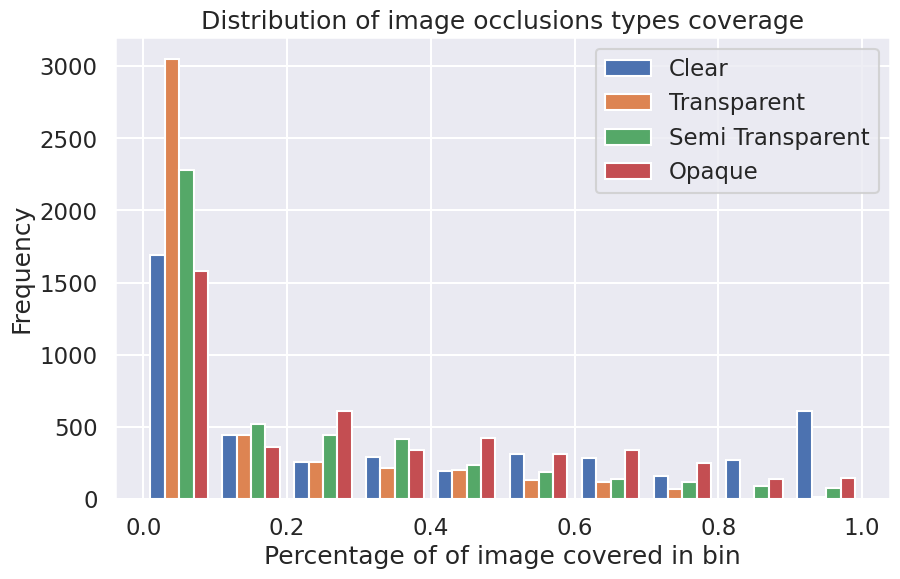

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


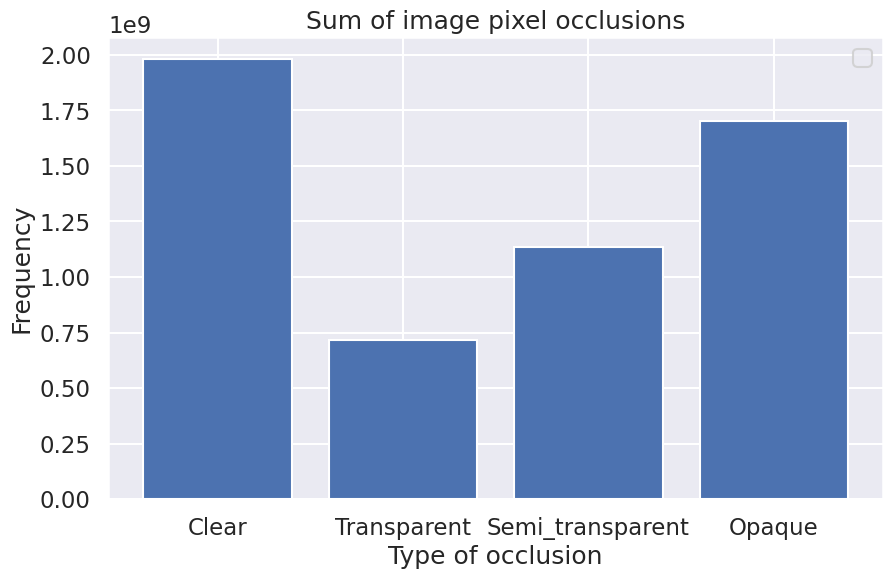

Clear               0.358076
Transparent         0.129509
Semi_transparent    0.204771
Opaque              0.307644
dtype: object


In [11]:
train_stats = labels_binning(gtLabelsPath_train, all_train)
visualize_labels_distribution_per_image(train_stats)
visualize_labels_distribution(train_stats)

In [12]:
gtLabelsPath_test.mkdir(exist_ok=True, parents=True)
rgbImagesPath_test.mkdir(exist_ok=True, parents=True)
rgbLabelsPath_test.mkdir(exist_ok=True, parents=True)


for selected_image_name in tqdm.tqdm(selection):
    shutil.copy(str(gtLabelsPath_source/selected_image_name), str(gtLabelsPath_test/selected_image_name))
    shutil.copy(str(rgbImagesPath_source/selected_image_name), str(rgbImagesPath_test/selected_image_name))
    shutil.copy(str(rgbLabelsPath_source/selected_image_name), str(rgbLabelsPath_test/selected_image_name))

100%|██████████| 497/497 [00:00<00:00, 729.21it/s]


100%|██████████| 497/497 [00:05<00:00, 88.01it/s]


We are processing occlusion level of Clear
We are processing occlusion level of Transparent
We are processing occlusion level of Semi_transparent
We are processing occlusion level of Opaque


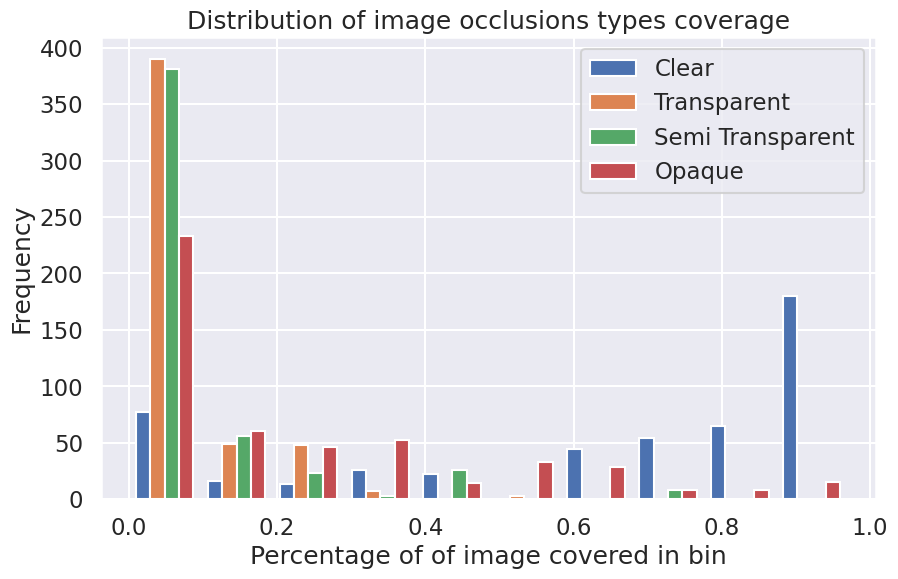

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


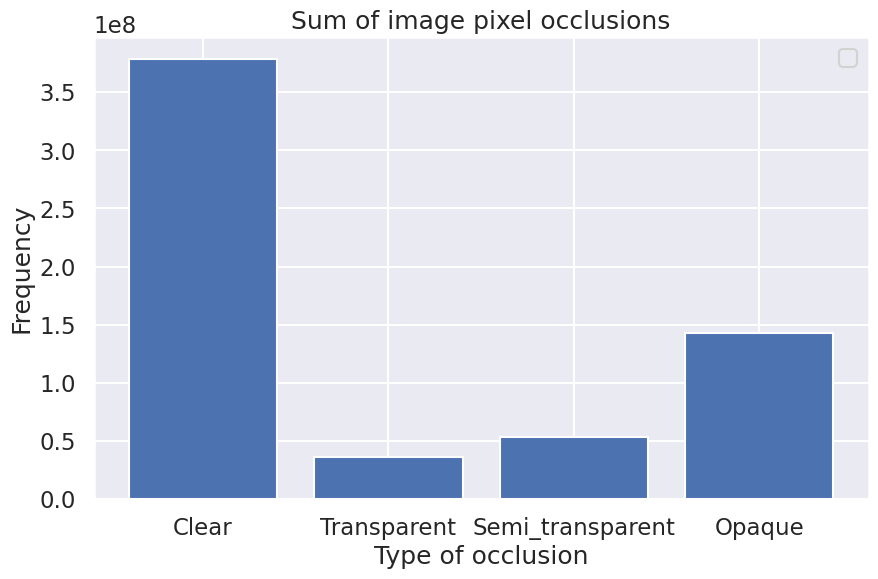

Clear               0.619765
Transparent         0.059798
Semi_transparent    0.086964
Opaque              0.233473
dtype: object


In [13]:
test_stats = labels_binning(gtLabelsPath_test, selection)
visualize_labels_distribution_per_image(test_stats)
visualize_labels_distribution(test_stats)

## Create .txt for file dataloader

In [14]:
all_files = df[df.Filename.isin(all_train)]

train_files = all_files[:3833]
val_files = all_files[3833:]

for dataset_name, dataset in zip(["train", "val"], [train_files, val_files]):
    correct_files = []
    file = open(gtLabelsPath_train.parent/f'{dataset_name}_all_files.txt','w')
    for filename in dataset["Filename"].to_list():
        file.write(f"/rgbImages/{filename},/gtLabels/{filename} \n")
        correct_files.append(f"./rgbImages/{filename},./gtLabels/{filename}")
    file.close()
    print(f"for dataset {dataset_name} there is num of files: {len(correct_files)}")

for dataset train there is num of files: 3833
for dataset val there is num of files: 670


100%|██████████| 3833/3833 [00:41<00:00, 91.58it/s]


We are processing occlusion level of Clear
We are processing occlusion level of Transparent
We are processing occlusion level of Semi_transparent
We are processing occlusion level of Opaque


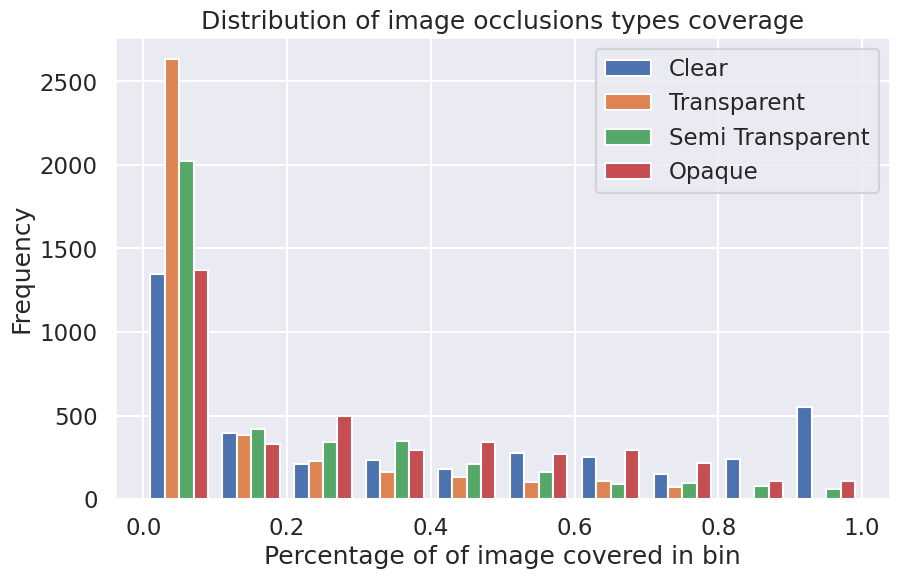

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


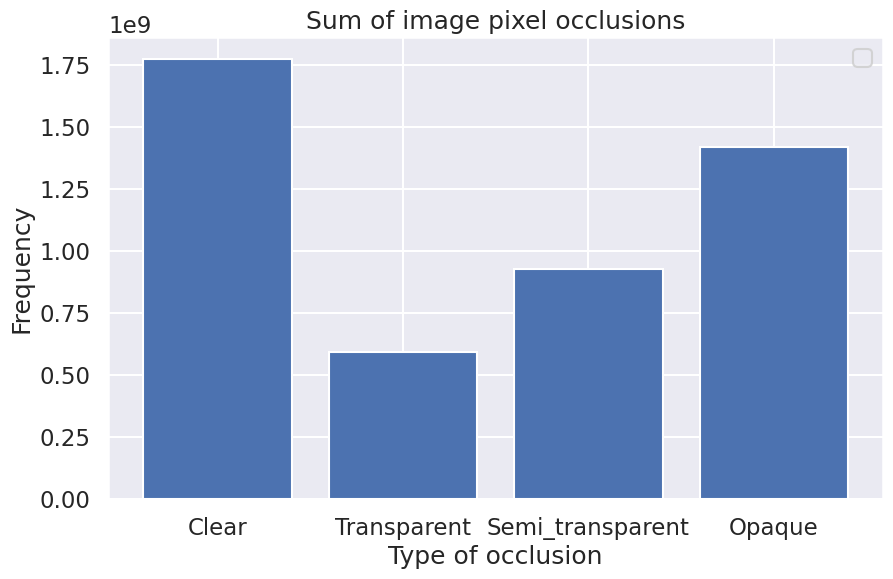

Clear               0.376468
Transparent         0.125442
Semi_transparent    0.196707
Opaque              0.301384
dtype: object


100%|██████████| 670/670 [00:07<00:00, 91.83it/s]


We are processing occlusion level of Clear
We are processing occlusion level of Transparent
We are processing occlusion level of Semi_transparent
We are processing occlusion level of Opaque


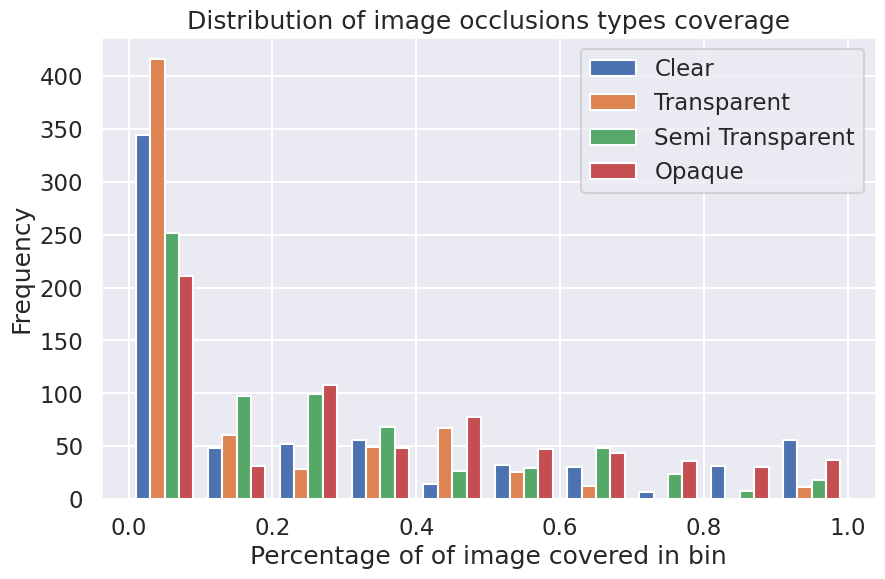

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


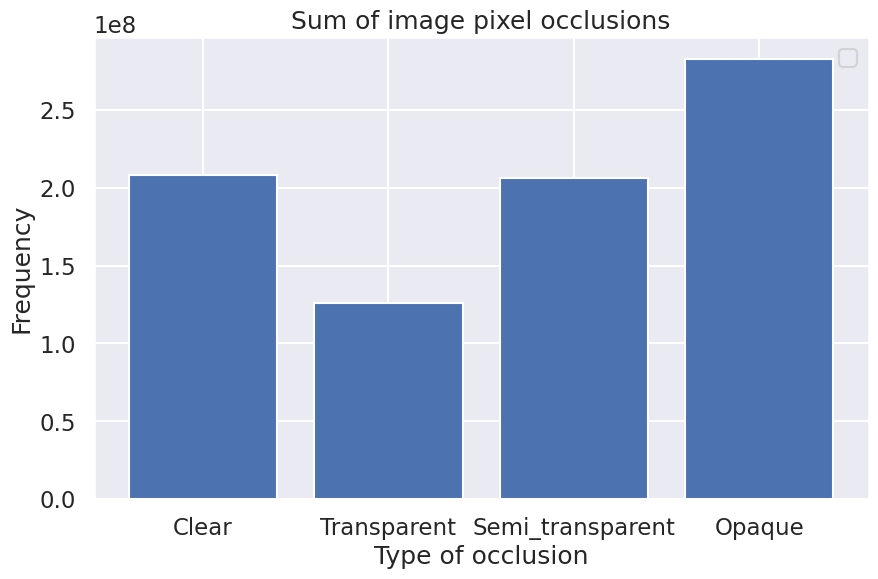

Clear               0.252857
Transparent         0.152778
Semi_transparent    0.250907
Opaque              0.343458
dtype: object


In [15]:
train_all_stats = labels_binning(gtLabelsPath_train, train_files["Filename"].to_list())
visualize_labels_distribution_per_image(train_all_stats)
visualize_labels_distribution(train_all_stats)
val_all_stats = labels_binning(gtLabelsPath_train, val_files["Filename"].to_list())
visualize_labels_distribution_per_image(val_all_stats)
visualize_labels_distribution(val_all_stats)

In [16]:
all_files = df[df.Filename.isin(all_train)]
correct_files = all_files[all_files["To be deleted"].isna()]

train_files = correct_files[:3148]
val_files = correct_files[3148:]

for dataset_name, dataset in zip(["train", "val"], [train_files, val_files]):
    correct_files = []
    file = open(gtLabelsPath_train.parent/f'{dataset_name}_correct_files.txt','w')
    for filename in dataset["Filename"].to_list():
        file.write(f"/rgbImages/{filename},/gtLabels/{filename} \n")
        correct_files.append(f"./rgbImages/{filename},./gtLabels/{filename}")
    file.close()
    print(f"for dataset {dataset_name} there is num of files: {len(correct_files)}")

for dataset train there is num of files: 3148
for dataset val there is num of files: 544


100%|██████████| 3148/3148 [00:34<00:00, 91.80it/s]


We are processing occlusion level of Clear
We are processing occlusion level of Transparent
We are processing occlusion level of Semi_transparent
We are processing occlusion level of Opaque


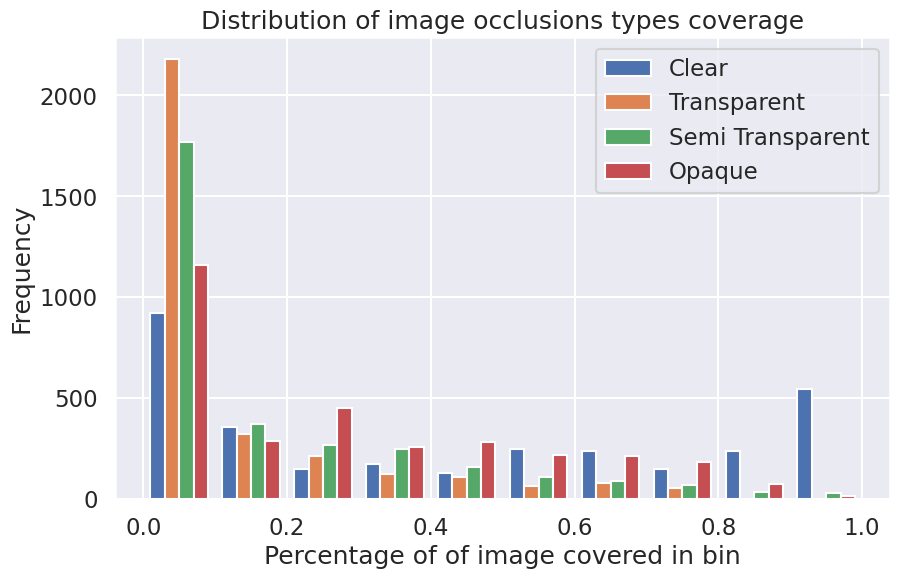

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


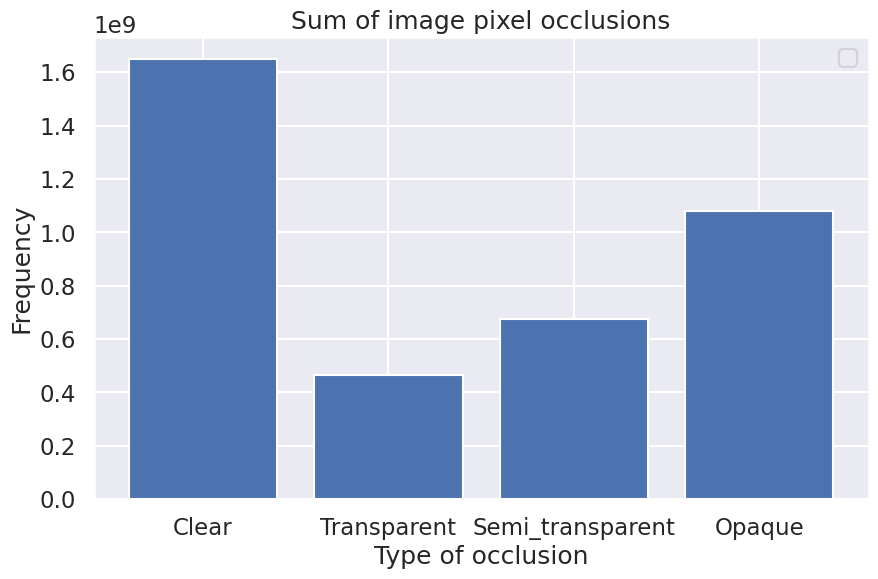

Clear               0.426355
Transparent         0.119811
Semi_transparent    0.174725
Opaque               0.27911
dtype: object


100%|██████████| 544/544 [00:05<00:00, 91.76it/s]


We are processing occlusion level of Clear
We are processing occlusion level of Transparent
We are processing occlusion level of Semi_transparent
We are processing occlusion level of Opaque


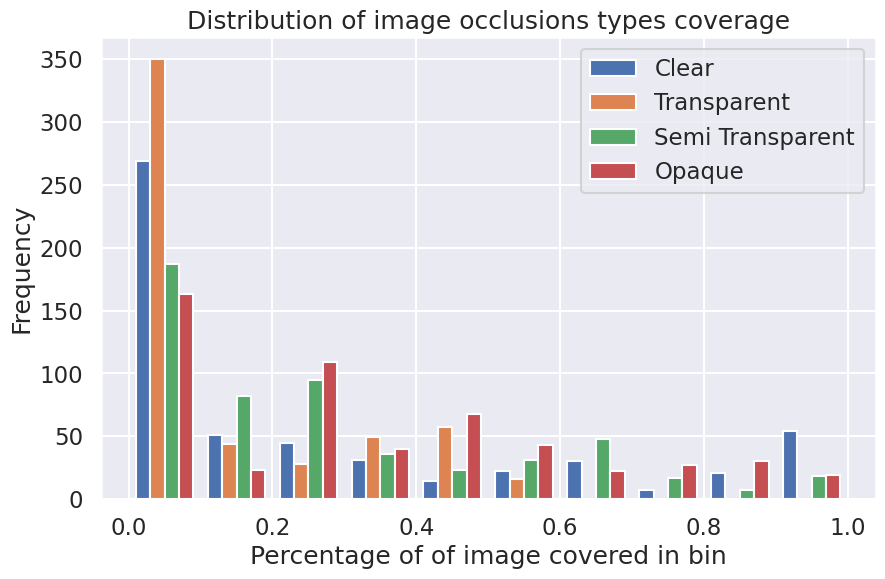

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


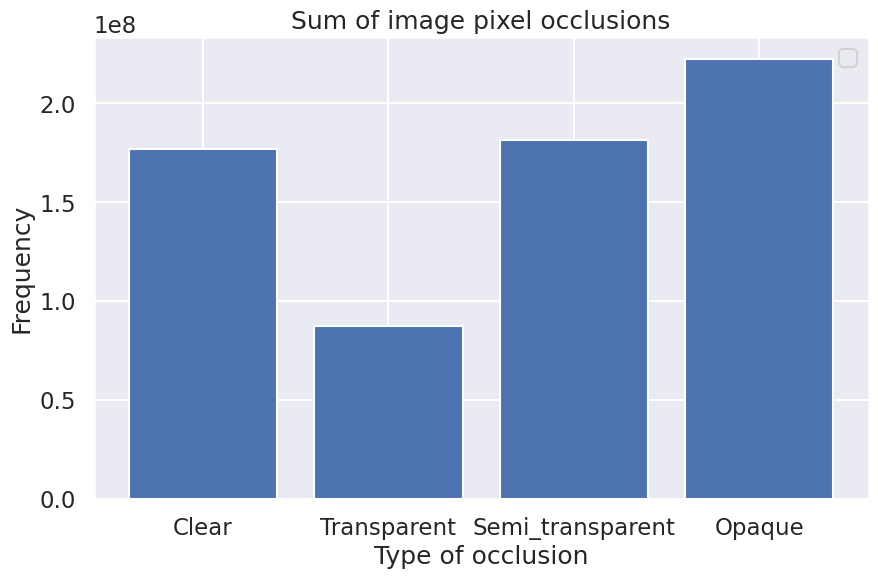

Clear               0.265008
Transparent         0.130632
Semi_transparent    0.271682
Opaque              0.332678
dtype: object


In [17]:
train_correct_stats = labels_binning(gtLabelsPath_train, train_files["Filename"].to_list())
visualize_labels_distribution_per_image(train_correct_stats)
visualize_labels_distribution(train_correct_stats)
val_correct_stats = labels_binning(gtLabelsPath_train, val_files["Filename"].to_list())
visualize_labels_distribution_per_image(val_correct_stats)
visualize_labels_distribution(val_correct_stats)

In [18]:
all_files = df[df.Filename.isin(all_train)]
clear_mask = all_files["Unclear"].isna()
correct_mask = all_files["To be deleted"].isna()
clear_files = all_files[clear_mask & correct_mask]

train_files = clear_files[:2629]
val_files = clear_files[2629:]


for dataset_name, dataset in zip(["train", "val"], [train_files, val_files]):
    correct_files = []
    file = open(gtLabelsPath_train.parent/f'{dataset_name}_correct_clear_files.txt','w')
    for filename in dataset["Filename"].to_list():
        file.write(f"/rgbImages/{filename},/gtLabels/{filename} \n")
        correct_files.append(f"./rgbImages/{filename},./gtLabels/{filename}")
    file.close()
    print(f"for dataset {dataset_name} there is num of files: {len(correct_files)}")

for dataset train there is num of files: 2629
for dataset val there is num of files: 461


100%|██████████| 2629/2629 [00:28<00:00, 90.96it/s]


We are processing occlusion level of Clear
We are processing occlusion level of Transparent
We are processing occlusion level of Semi_transparent
We are processing occlusion level of Opaque


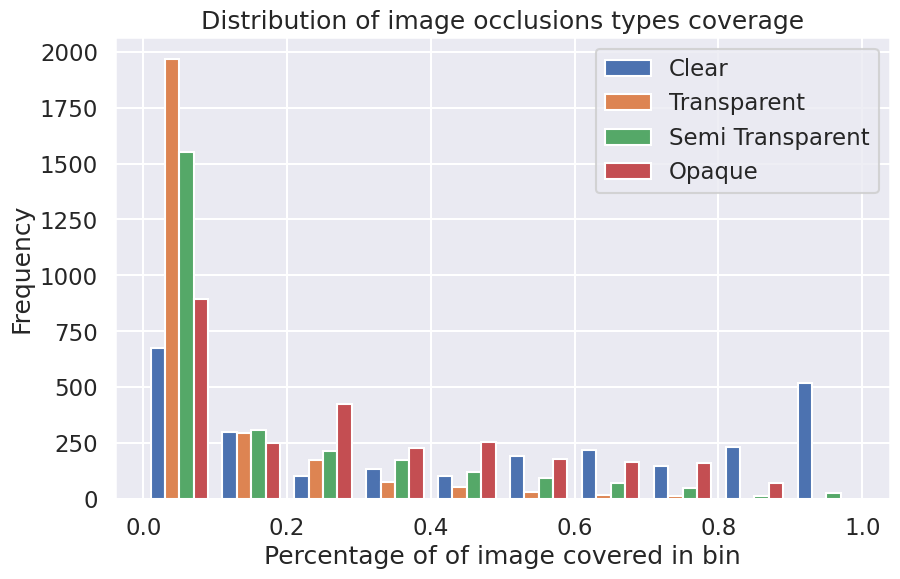

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


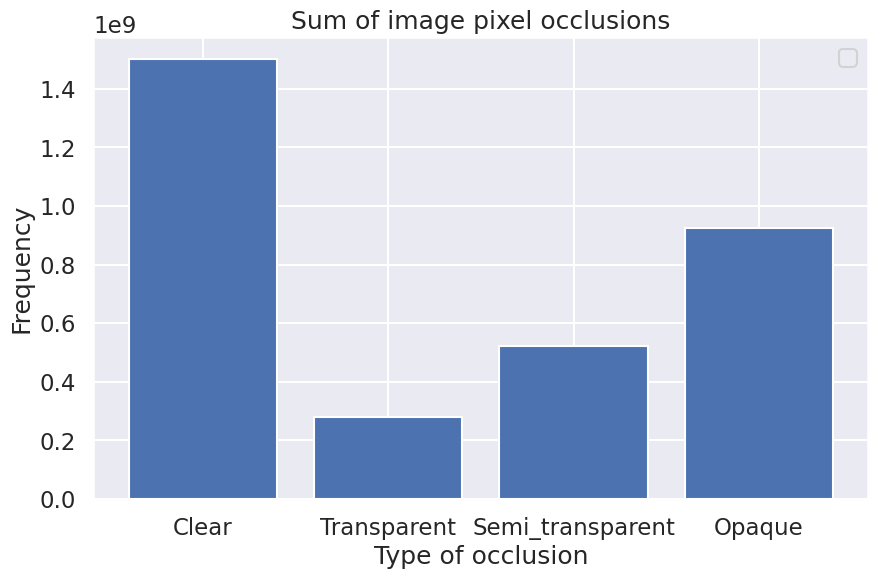

Clear               0.464612
Transparent         0.087068
Semi_transparent    0.162049
Opaque              0.286271
dtype: object


100%|██████████| 461/461 [00:05<00:00, 90.16it/s]


We are processing occlusion level of Clear
We are processing occlusion level of Transparent
We are processing occlusion level of Semi_transparent
We are processing occlusion level of Opaque


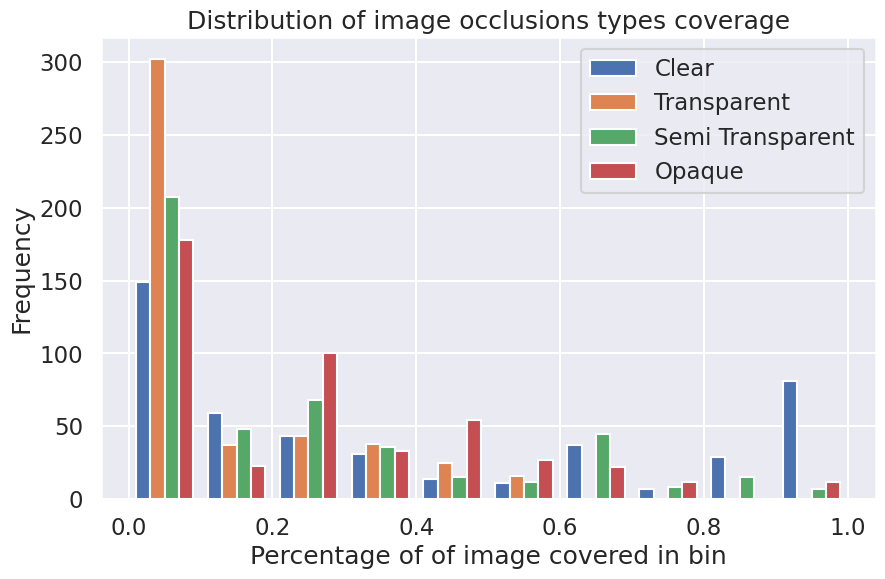

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


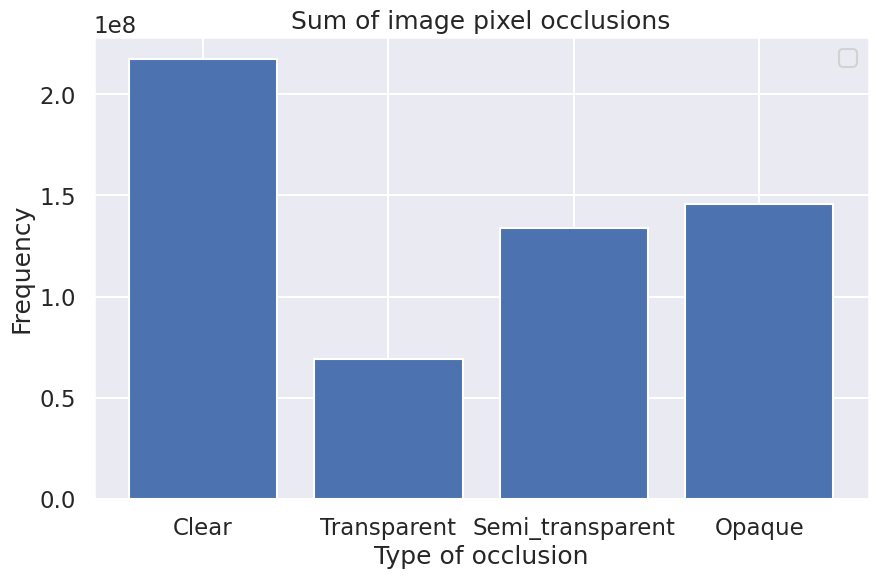

Clear               0.383757
Transparent         0.122264
Semi_transparent    0.236606
Opaque              0.257373
dtype: object


In [19]:
train_clear_stats = labels_binning(gtLabelsPath_train, train_files["Filename"].to_list())
visualize_labels_distribution_per_image(train_clear_stats)
visualize_labels_distribution(train_clear_stats)
val_clear_stats = labels_binning(gtLabelsPath_train, val_files["Filename"].to_list())
visualize_labels_distribution_per_image(val_clear_stats)
visualize_labels_distribution(val_clear_stats)

In [20]:
all_files = df[df.Filename.isin(all_train)]
strict_delete_mask = all_files["Strict delete"].isna()
strict_files = all_files[strict_delete_mask]

train_files = strict_files[:1254]
val_files = strict_files[1254:]

for dataset_name, dataset in zip(["train", "val"], [train_files, val_files]):
    correct_files = []
    file = open(gtLabelsPath_train.parent/f'{dataset_name}_correct_clear_strict_files.txt','w')
    for filename in dataset["Filename"].to_list():
        file.write(f"/rgbImages/{filename},/gtLabels/{filename} \n")
        correct_files.append(f"./rgbImages/{filename},./gtLabels/{filename}")
    file.close()
    print(f"for dataset {dataset_name} there is num of files: {len(correct_files)}")

for dataset train there is num of files: 1254
for dataset val there is num of files: 185


100%|██████████| 1254/1254 [00:14<00:00, 88.80it/s]


We are processing occlusion level of Clear
We are processing occlusion level of Transparent
We are processing occlusion level of Semi_transparent
We are processing occlusion level of Opaque


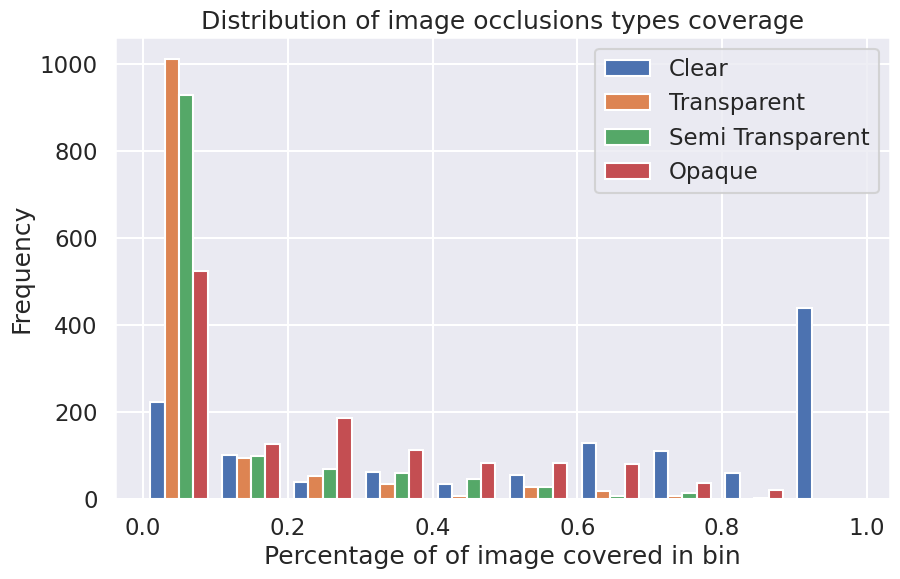

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


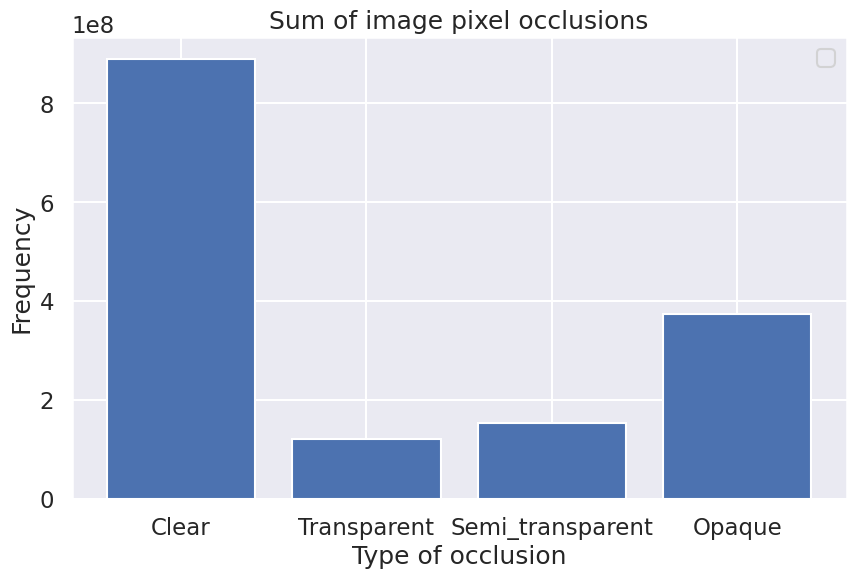

Clear               0.577232
Transparent         0.078865
Semi_transparent    0.100459
Opaque              0.243444
dtype: object


100%|██████████| 185/185 [00:02<00:00, 91.56it/s]


We are processing occlusion level of Clear
We are processing occlusion level of Transparent
We are processing occlusion level of Semi_transparent
We are processing occlusion level of Opaque


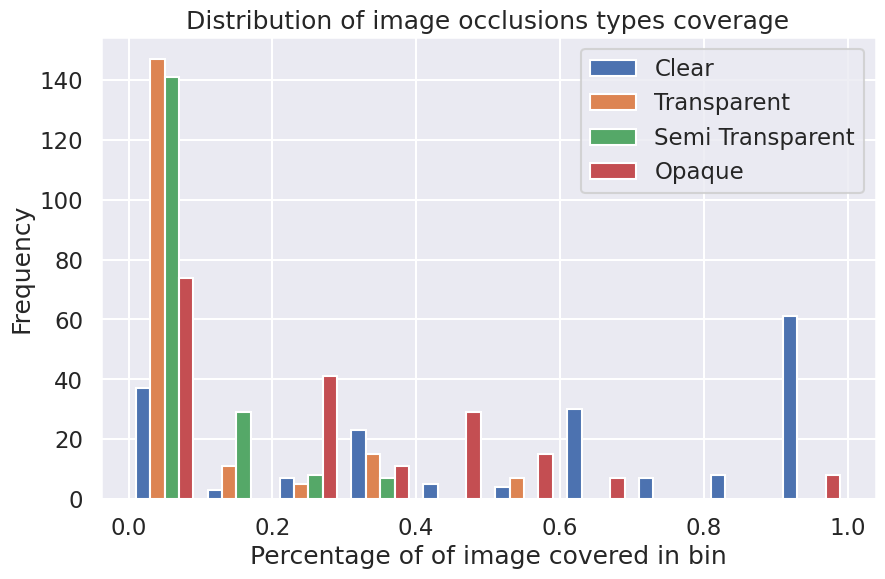

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


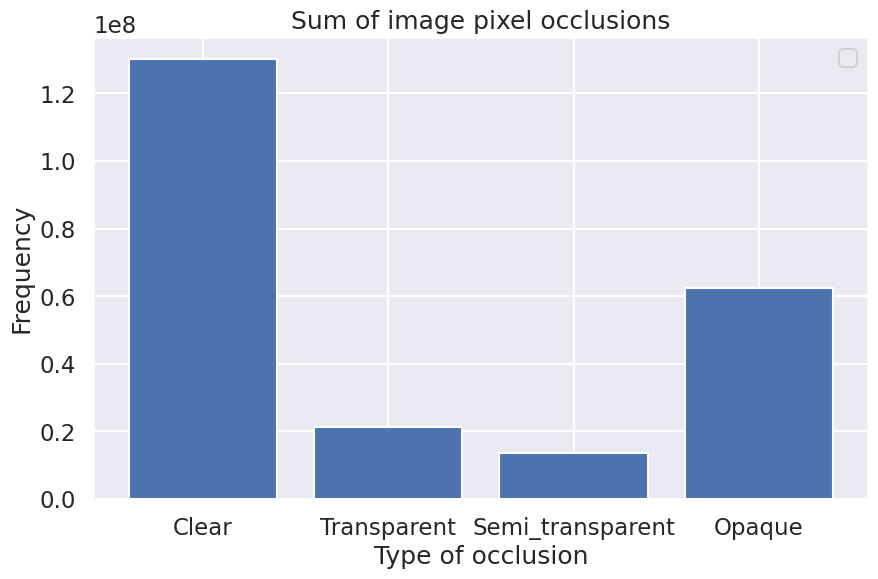

Clear               0.572621
Transparent         0.093263
Semi_transparent    0.059699
Opaque              0.274416
dtype: object


In [21]:
train_strict_stats = labels_binning(gtLabelsPath_train, train_files["Filename"].to_list())
visualize_labels_distribution_per_image(train_strict_stats)
visualize_labels_distribution(train_strict_stats)
val_strict_stats = labels_binning(gtLabelsPath_train, val_files["Filename"].to_list())
visualize_labels_distribution_per_image(val_strict_stats)
visualize_labels_distribution(val_strict_stats)

In [35]:
selection_df = df[df["Strict delete"]!="nok"]
test_df = pd.concat([selection_df[:249], selection_df[-248:]])

correct_files = []
file = open(gtLabelsPath_test.parent/f'test_all_files.txt','w')
for filename in test_df["Filename"].to_list():
    file.write(f"/rgbImages/{filename},/gtLabels/{filename} \n")
    correct_files.append(f"./rgbImages/{filename},./gtLabels/{filename}")
file.close()
print(f"for dataset test there is num of files: {len(correct_files)}")

for dataset test there is num of files: 497


100%|██████████| 497/497 [00:05<00:00, 86.92it/s]


We are processing occlusion level of Clear
We are processing occlusion level of Transparent
We are processing occlusion level of Semi_transparent
We are processing occlusion level of Opaque


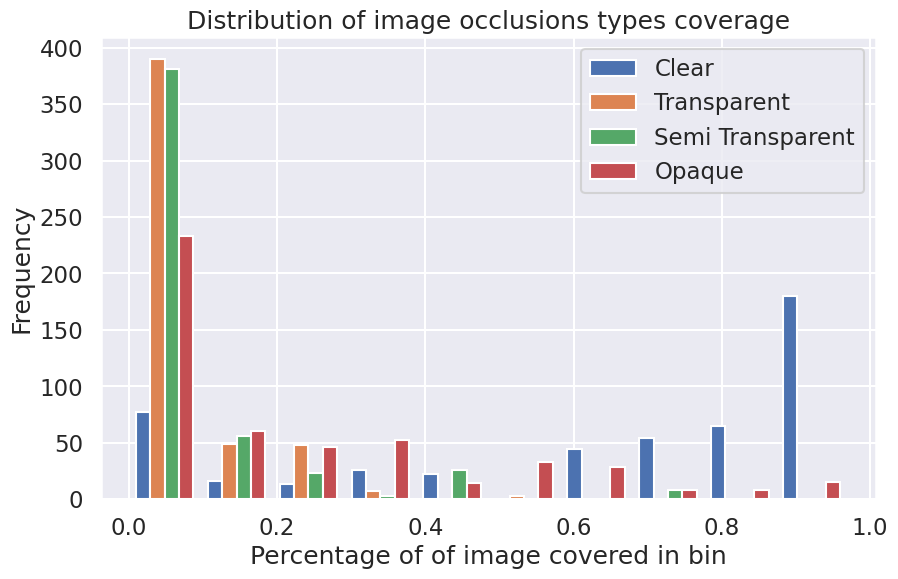

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


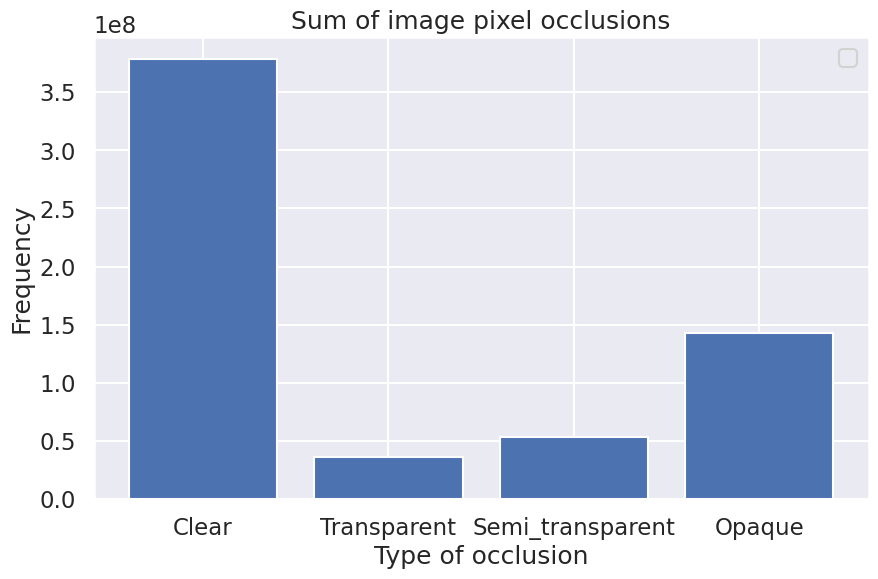

Clear               0.619765
Transparent         0.059798
Semi_transparent    0.086964
Opaque              0.233473
dtype: object


In [36]:
test_all_stats = labels_binning(gtLabelsPath_test, test_df["Filename"].to_list())
visualize_labels_distribution_per_image(test_all_stats)
visualize_labels_distribution(test_all_stats)